# Analysing COVID-19 Data

Here we'll look at the most relevant dataset to our lives at the moment: the global spread of COVID-19.   There is an open dataset avaialable that is updated often showing the number of cases in different regions of the world.  This is the source of the graphs and visualisations that we see on the news. 

Here are some sample stories for reference:

* [From the ABC](https://www.abc.net.au/news/2020-03-26/coronavirus-covid19-global-spread-data-explained/12089028)
* [From the Guardian](https://www.theguardian.com/australia-news/datablog/ng-interactive/2020/apr/06/coronavirus-cases-in-australia-map-curve-confirmed-numbers-stats-how-many-covid-19-nsw-by-postcode-maps-victoria-live-data-qld-sa-wa-tas-nt-act-latest-statistics)
* [Coronavirus in Australia](https://www.covid19data.com.au/)
* [ArcGIS Dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) Johns Hopkins


In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from matplotlib import pyplot as plt

plt.style.use('seaborn')

%matplotlib inline

## Getting the Data

The first step is to get a copy of the raw data.  The data is being made available by Johns Hopkins University in [this GitHub repository](https://github.com/CSSEGISandData/COVID-19).

I will be reading the data directly from the URL in order to get live updates of the data.

In [2]:
# load the live dataset, assumes a working network connection
covid_data_url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
covid = pd.read_csv(covid_data_url)

In [3]:
covid.sample(10)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20
239,NaN,Libya,26.3351,17.228331,0,0,0,0,0,0,...,64,64,64,65,65,65,68,69,71,72
230,NaN,Zimbabwe,-20.0000,30.000000,0,0,0,0,0,0,...,37,37,42,42,44,46,46,48,51,51
109,Guadeloupe,France,16.2500,-61.583300,0,0,0,0,0,0,...,155,155,155,155,155,155,155,155,155,156
146,NaN,Latvia,56.8796,24.603200,0,0,0,0,0,0,...,951,962,970,997,1008,1009,1012,1016,1025,1030
128,NaN,Honduras,15.2000,-86.241900,0,0,0,0,0,0,...,2255,2318,2460,2565,2646,2798,2955,2955,3204,3477
140,NaN,Jordan,31.2400,36.510000,0,0,0,0,0,0,...,582,586,596,607,613,629,649,672,684,700
173,NaN,Nigeria,9.0820,8.675300,0,0,0,0,0,0,...,4971,5162,5450,5621,5959,6175,6401,6677,7016,7261
258,Saint Pierre and Miquelon,France,46.8852,-56.315900,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
104,NaN,Ethiopia,9.1450,40.489700,0,0,0,0,0,0,...,263,272,287,306,317,352,365,389,399,433
166,Aruba,Netherlands,12.5186,-70.035800,0,0,0,0,0,0,...,101,101,101,101,101,101,101,101,101,101


## Exploring the Data

The format of this data is one row per geographical region with columns for Lat/Long and then one column for each day's data.  Most regions are countries but in some cases, as in Australia, they are states.  

For the analysis I want to do I'll look at data for countries only, so my first operation on the data frame would be to combine all of the rows for countries like Australia that are split into states.  I will then drop the non-numeric columns to leave just the numbers on each day for each country. I will do this to make a new dataframe containing just the numerical data.

In [4]:
grouped = covid.groupby('Country/Region').sum()
grouped = grouped.drop(columns=['Lat', 'Long'])

In [5]:
grouped.sample(10)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,5/13/20,5/14/20,5/15/20,5/16/20,5/17/20,5/18/20,5/19/20,5/20/20,5/21/20,5/22/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Romania,0,0,0,0,0,0,0,0,0,0,...,16002,16247,16437,16704,16871,17036,17191,17387,17585,17712
Qatar,0,0,0,0,0,0,0,0,0,0,...,26539,28272,29425,30972,32604,33969,35606,37097,38651,40481
Cameroon,0,0,0,0,0,0,0,0,0,0,...,2800,2954,3105,3105,3105,3529,3529,3733,4288,4400
Greece,0,0,0,0,0,0,0,0,0,0,...,2760,2770,2810,2819,2834,2836,2840,2850,2853,2874
Netherlands,0,0,0,0,0,0,0,0,0,0,...,43410,43680,43880,44070,44195,44341,44449,44647,44900,45088
Grenada,0,0,0,0,0,0,0,0,0,0,...,21,21,22,22,22,22,22,22,22,22
Syria,0,0,0,0,0,0,0,0,0,0,...,48,48,50,51,58,58,58,58,58,59
Diamond Princess,0,0,0,0,0,0,0,0,0,0,...,712,712,712,712,712,712,712,712,712,712
Paraguay,0,0,0,0,0,0,0,0,0,0,...,740,754,759,778,786,788,829,833,836,838


It can be seen that all the states are combined into countries to be created as labels using the groupby method. The excess numerical values like latitude and longitude are dropped from the table, so that the rate of increase of the confirmed cases can be easily determined for any given country.

You can now select just the data for one country [using the `loc` method](https://pandas.pydata.org/docs/getting_started/10min.html#selection) since the new dataframe will have the grouped values (Countries) as the row labels. Select the data for one country (you choose which) and plot it.  You should see the exponential rise in case numbers over time.

In [6]:
grouped.loc['China']

1/22/20      548
1/23/20      643
1/24/20      920
1/25/20     1406
1/26/20     2075
           ...  
5/18/20    84063
5/19/20    84063
5/20/20    84063
5/21/20    84063
5/22/20    84081
Name: China, Length: 122, dtype: int64

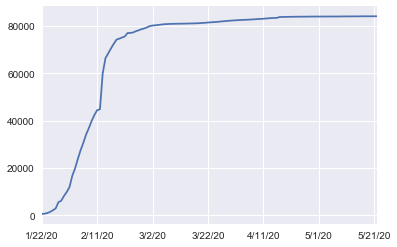

In [7]:
grouped.loc['China'].plot()

Using the loc method, the confirmed cases data for China was singled out. Combined with the plot function, the data was represented in a graph, where the y-axis represents the number of confirmed cases and the x-axis represents the corresponding dates. Initially a rapid exponential rise could be seen in the amount of confirmed cases, with a sudden flattening of the curve.

## Comparing Countries

One of the classic displays in the news is the comparison between countries.  I am going to select a number of countries and plot their data on the same graph to reproduce this visualisation. I would do this for countries with significant outbreaks, such as - China, Spain, Italy, UK, Australia. 

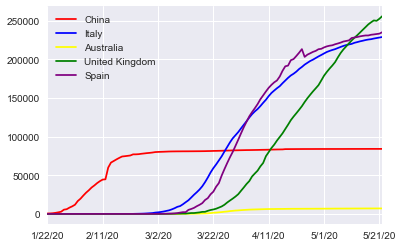

In [9]:
grouped.loc['China'].plot(color = 'red')
grouped.loc['Italy'].plot(color = 'blue')
grouped.loc['Australia'].plot(color = 'yellow')
grouped.loc['United Kingdom'].plot(color = 'green')
grouped.loc['Spain'].plot(color = 'purple')
plt.legend()

Plotting the data of different countries on the same graph gives us a visualisation of the rate of confirmed cases for each country. It can be seen from th plot that while China had the greatest exponential rise of confirmed cases initially, the rate eventually flattened out. Where as for Italy, UK and Spain, number of confirmed cases were nil initially. However the outbreak started at a later date in these countries, between 2nd and 22nd March, with Spain having the highest amount of confirmed cases (more than 200000) according to latest intel. Australia has the lowest number of confirmed cases among these countries. 

## Normalisation by Population

The raw data includes the overall count of cases in each country. Clearly small countries will have smaller overall values than large countries.  It would be interesting to see whether the number of cases in China and the US was more per-capita than those in other countries and find which country has the highest number as a proportion of the population. A good way to measure this is the number of cases per million people in the population. For example, if a country has 25 cases and a population of 2.5 million they would have 10 cases per million.

To answer these questions we need population data. The dataset that I'm going to use for this purpose is [datahub.io](https://datahub.io/JohnSnowLabs/population-figures-by-country) which has data per country up to 2016 in a handy CSV format. I would use this data set to compute the number of confirmed cases for each country per million population. Then I would create a new plot with this data to compare the most recent day's data and find out which country has the most cases per million right now. 

In [10]:
population = pd.read_csv('data/population-figures-by-country-csv_csv.csv', index_col='Country')
population.sample(5)

,Country_Code,Year_1960,Year_1961,Year_1962,Year_1963,Year_1964,Year_1965,Year_1966,Year_1967,Year_1968,...,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016
Country,,,,,,,,,,,,,,,,,,,,,
Zimbabwe,ZWE,3747369.0,3870756.0,3999419.0,4132756.0,4269863.0,4410212.0,4553433.0,4700041.0,4851431.0,...,1.332991e+07,1.355847e+07,1.381060e+07,1.408632e+07,1.438665e+07,1.471083e+07,1.505451e+07,1.541168e+07,1.577745e+07,1.615036e+07
China,CHN,667070000.0,660330000.0,665770000.0,682335000.0,698355000.0,715185000.0,735400000.0,754550000.0,774510000.0,...,1.317885e+09,1.324655e+09,1.331260e+09,1.337705e+09,1.344130e+09,1.350695e+09,1.357380e+09,1.364270e+09,1.371220e+09,1.378665e+09
Uganda,UGA,6788214.0,7006633.0,7240174.0,7487429.0,7746198.0,8014401.0,8292776.0,8580676.0,8872920.0,...,3.059049e+07,3.166390e+07,3.277190e+07,3.391513e+07,3.509365e+07,3.630680e+07,3.755373e+07,3.883334e+07,4.014487e+07,4.148796e+07
Iraq,IRQ,7289761.0,7475352.0,7674223.0,7888914.0,8122199.0,8375793.0,8651164.0,8947404.0,9260682.0,...,2.839043e+07,2.911142e+07,2.989465e+07,3.076270e+07,3.172705e+07,3.277657e+07,3.388314e+07,3.500608e+07,3.611565e+07,3.720257e+07
Kenya,KEN,8105440.0,8361441.0,8628972.0,8908422.0,9200157.0,9504703.0,9822499.0,10154484.0,10502245.0,...,3.808591e+07,3.914842e+07,4.023720e+07,4.135015e+07,4.248684e+07,4.364663e+07,4.482685e+07,4.602425e+07,4.723626e+07,4.846157e+07


In [11]:
pop_infect = pd.merge(grouped,population,right_index=True,left_index=True)
pop_infect.sample(5)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,Year_2007,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016
Mauritania,0,0,0,0,0,0,0,0,0,0,...,3312665.0,3407541.0,3506288.0,3609543.0,3717672.0,3830239.0,3946170.0,4063920.0,4182341.0,4301018.0
Japan,2,2,2,2,4,4,7,7,11,15,...,128001000.0,128063000.0,128047000.0,128070000.0,127833000.0,127629000.0,127445000.0,127276000.0,127141000.0,126994511.0
Guyana,0,0,0,0,0,0,0,0,0,0,...,747869.0,746314.0,745693.0,746556.0,749100.0,753091.0,758081.0,763393.0,768514.0,773303.0
Dominican Republic,0,0,0,0,0,0,0,0,0,0,...,9504353.0,9636520.0,9767758.0,9897985.0,10027095.0,10154950.0,10281296.0,10405844.0,10528394.0,10648791.0
Vietnam,0,2,2,2,2,2,2,2,2,2,...,84218500.0,85118700.0,86025000.0,86932500.0,87860300.0,88809200.0,89759500.0,90728900.0,91713300.0,92701100.0


In [12]:
population_in_million = pop_infect['Year_2016']/1000000
infected_per_million = (pop_infect['5/21/20']/population_in_million).round()

pop_infect = pop_infect.assign(infected_per_million = infected_per_million)
pop_infect

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,Year_2008,Year_2009,Year_2010,Year_2011,Year_2012,Year_2013,Year_2014,Year_2015,Year_2016,infected_per_million
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,27294031.0,28004331.0,28803167.0,29708599.0,30696958.0,31731688.0,32758020.0,33736494.0,34656032.0,250.0
Albania,0,0,0,0,0,0,0,0,0,0,...,2947314.0,2927519.0,2913021.0,2905195.0,2900401.0,2895092.0,2889104.0,2880703.0,2876101.0,337.0
Algeria,0,0,0,0,0,0,0,0,0,0,...,34860715.0,35465760.0,36117637.0,36819558.0,37565847.0,38338562.0,39113313.0,39871528.0,40606052.0,190.0
Andorra,0,0,0,0,0,0,0,0,0,0,...,83861.0,84462.0,84449.0,83751.0,82431.0,80788.0,79223.0,78014.0,77281.0,9860.0
Angola,0,0,0,0,0,0,0,0,0,0,...,21759420.0,22549547.0,23369131.0,24218565.0,25096150.0,25998340.0,26920466.0,27859305.0,28813463.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,0,0,0,0,0,0,0,0,0,0,...,27302800.0,27767400.0,28562400.0,29339400.0,29774500.0,30243200.0,30757700.0,31298900.0,31848200.0,93.0
Vietnam,0,2,2,2,2,2,2,2,2,2,...,85118700.0,86025000.0,86932500.0,87860300.0,88809200.0,89759500.0,90728900.0,91713300.0,92701100.0,3.0
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,3596688.0,3702218.0,3811102.0,3927051.0,4046901.0,4169506.0,4294682.0,4422143.0,4551566.0,93.0
Zambia,0,0,0,0,0,0,0,0,0,0,...,13082517.0,13456417.0,13850033.0,14264756.0,14699937.0,15153210.0,15620974.0,16100587.0,16591390.0,52.0


In [13]:
maxValue = pop_infect['infected_per_million'].max()
 
print('Maximum number of infected per million population: ')
print(maxValue)

Maximum number of infected per million population: 
19817.0


Text(0, 0.5, 'Infected per million')

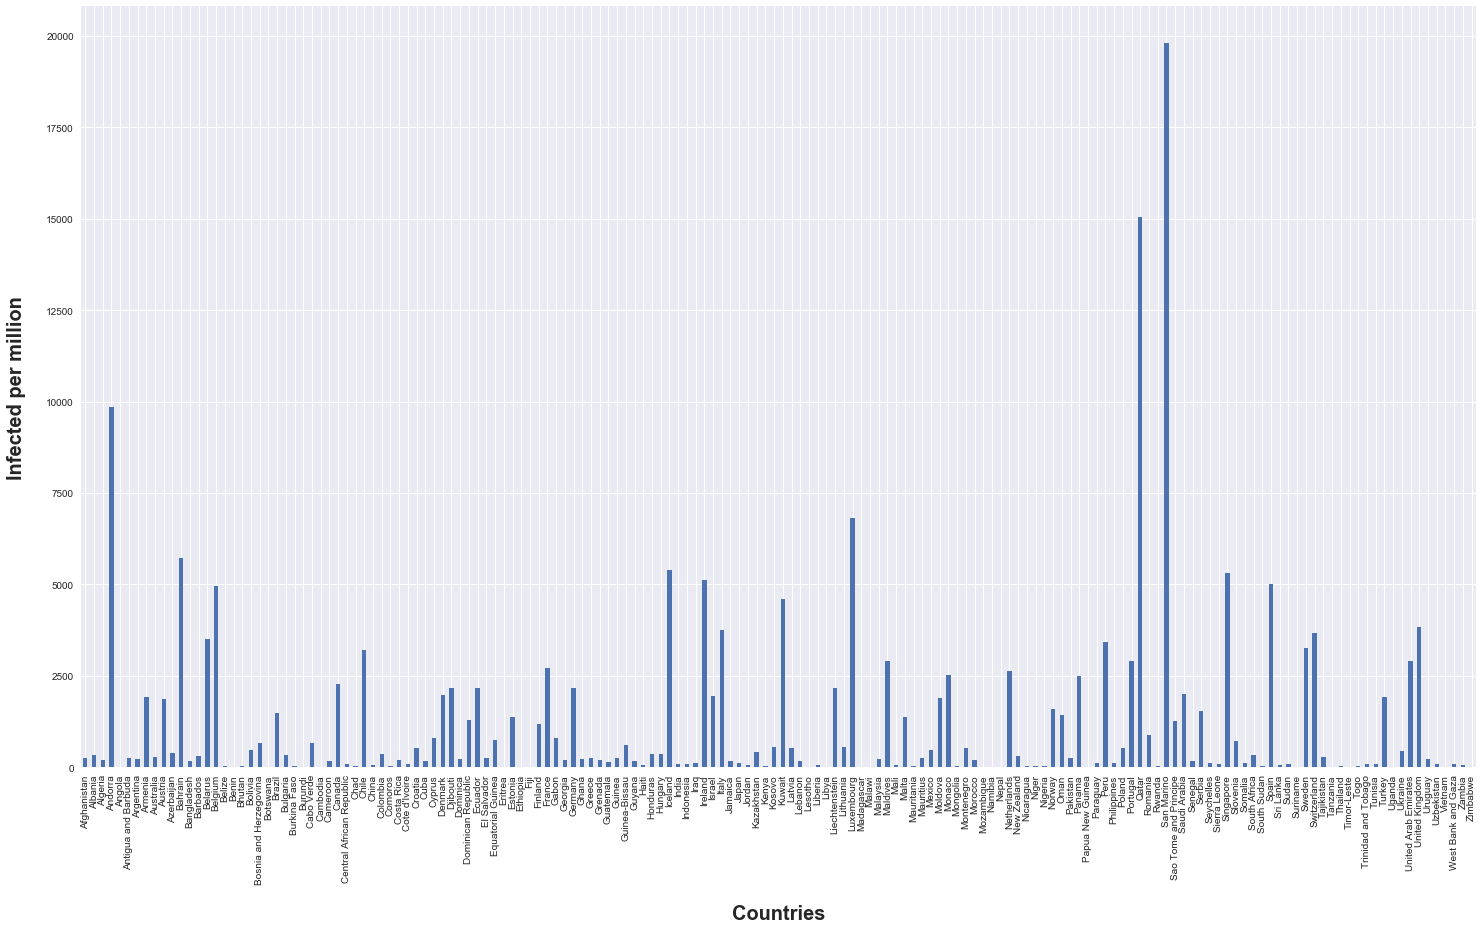

In [14]:
per_mil = pop_infect['infected_per_million'].plot.bar(figsize=(25,14), stacked=True, zorder=2)
plt.xlabel("Countries",labelpad=20, weight='bold', size=20)
plt.ylabel("Infected per million", labelpad=20, weight='bold', size=20)

From the bar graph above, it can clearly be seen that one country stands out from the others with respect to the number of infected people per million population. The name of the country is San Marino and it has 19817 infected people per million of its population. Qatar is a close second with around 15000 infected per million population. (Due to the limitation of population data, it is considered that the population of the countries today is the same as it was on 2016)

## Creating a simple Predictive Model

It is well understood that the spread of the virus follows an exponential pattern. This is because each infected person infects more than one new person on average, leading to exponential growth.  This is why the key to stopping the growth of the pandemic is to reduce the number of people infected by stopping contact and isolating infected poeple. 

An exponential curve has the equation $y = e^{mx}$. It can be converted to a linear relationship by taking the logarithm of each side: $log(y) = mx$.  This means that we can fit a linear regression model to the data as long as we take the log of the number of cases. 

I will select the data for USA as it has a clear exponential curve and build a linear regression model to predict the log of the number of case. Then I would test how well the model fits the data. 

Then I would select the data from China. This should show some divergence from the model since they have managed to slow the growth of cases.

In [27]:
transposed_data=grouped.transpose()

final_data = transposed_data.rename(columns={'Country/Region': 'Dates'})
final_data.head()

Country/Region,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Kingdom,Uruguay,Uzbekistan,Venezuela,Vietnam,West Bank and Gaza,Western Sahara,Yemen,Zambia,Zimbabwe
1/22/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1/24/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1/25/20,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
1/26/20,0,0,0,0,0,0,0,0,4,0,...,0,0,0,0,2,0,0,0,0,0


### Modeling for USA

In [35]:
regression_us = final_data['US']
logged_us = np.log(regression_us)
logged_us_df = pd.DataFrame(logged_us)
logged_us_df

,US
1/22/20,0.000000
1/23/20,0.000000
1/24/20,0.693147
1/25/20,0.693147
1/26/20,1.609438
...,...
5/18/20,14.226499
5/19/20,14.239842
5/20/20,14.254960
5/21/20,14.271128


In [37]:
logged_us_df['Day'] = range(len(logged_us_df))
logged_us_df

,US,Day
1/22/20,0.000000,0
1/23/20,0.000000,1
1/24/20,0.693147,2
1/25/20,0.693147,3
1/26/20,1.609438,4
...,...,...
5/18/20,14.226499,117
5/19/20,14.239842,118
5/20/20,14.254960,119
5/21/20,14.271128,120


In [39]:
reg = linear_model.LinearRegression()
X = logged_us_df[['Day']]
y = logged_us_df['US']
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [40]:
predicted_us = reg.predict(logged_us_df[['Day']])

In [41]:
predicted_us

array([ 0.43006663,  0.56722339,  0.70438016,  0.84153692,  0.97869368,
        1.11585044,  1.2530072 ,  1.39016397,  1.52732073,  1.66447749,
        1.80163425,  1.93879101,  2.07594778,  2.21310454,  2.3502613 ,
        2.48741806,  2.62457483,  2.76173159,  2.89888835,  3.03604511,
        3.17320187,  3.31035864,  3.4475154 ,  3.58467216,  3.72182892,
        3.85898568,  3.99614245,  4.13329921,  4.27045597,  4.40761273,
        4.5447695 ,  4.68192626,  4.81908302,  4.95623978,  5.09339654,
        5.23055331,  5.36771007,  5.50486683,  5.64202359,  5.77918035,
        5.91633712,  6.05349388,  6.19065064,  6.3278074 ,  6.46496417,
        6.60212093,  6.73927769,  6.87643445,  7.01359121,  7.15074798,
        7.28790474,  7.4250615 ,  7.56221826,  7.69937502,  7.83653179,
        7.97368855,  8.11084531,  8.24800207,  8.38515883,  8.5223156 ,
        8.65947236,  8.79662912,  8.93378588,  9.07094265,  9.20809941,
        9.34525617,  9.48241293,  9.61956969,  9.75672646,  9.89

In [43]:
r2 = r2_score(y, predicted_us)
r2

0.9256859223014735

The R-squared value for the model is quite high (around 93%). This shows that the model fits the data for USA very well as it has an exponential growth.

### Modeling for China

In [44]:
regression_ch = final_data['China']
logged_ch = np.log(regression_ch)
logged_ch_df = pd.DataFrame(logged_ch)
logged_ch_df

,China
1/22/20,6.306275
1/23/20,6.466145
1/24/20,6.824374
1/25/20,7.248504
1/26/20,7.637716
...,...
5/18/20,11.339322
5/19/20,11.339322
5/20/20,11.339322
5/21/20,11.339322


In [45]:
logged_ch_df['Day'] = range(len(logged_ch_df))
logged_ch_df

,China,Day
1/22/20,6.306275,0
1/23/20,6.466145,1
1/24/20,6.824374,2
1/25/20,7.248504,3
1/26/20,7.637716,4
...,...,...
5/18/20,11.339322,117
5/19/20,11.339322,118
5/20/20,11.339322,119
5/21/20,11.339322,120


In [46]:
reg = linear_model.LinearRegression()
X = logged_ch_df[['Day']]
y = logged_ch_df['China']
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
predicted_ch = reg.predict(logged_ch_df[['Day']])
predicted_ch

array([ 9.84211455,  9.859842  ,  9.87756945,  9.89529689,  9.91302434,
        9.93075179,  9.94847923,  9.96620668,  9.98393413, 10.00166157,
       10.01938902, 10.03711647, 10.05484391, 10.07257136, 10.09029881,
       10.10802625, 10.1257537 , 10.14348115, 10.16120859, 10.17893604,
       10.19666349, 10.21439093, 10.23211838, 10.24984583, 10.26757327,
       10.28530072, 10.30302817, 10.32075561, 10.33848306, 10.35621051,
       10.37393795, 10.3916654 , 10.40939285, 10.42712029, 10.44484774,
       10.46257519, 10.48030263, 10.49803008, 10.51575752, 10.53348497,
       10.55121242, 10.56893986, 10.58666731, 10.60439476, 10.6221222 ,
       10.63984965, 10.6575771 , 10.67530454, 10.69303199, 10.71075944,
       10.72848688, 10.74621433, 10.76394178, 10.78166922, 10.79939667,
       10.81712412, 10.83485156, 10.85257901, 10.87030646, 10.8880339 ,
       10.90576135, 10.9234888 , 10.94121624, 10.95894369, 10.97667114,
       10.99439858, 11.01212603, 11.02985348, 11.04758092, 11.06

In [49]:
r2 = r2_score(y, predicted_ch)
r2.round(2)

0.37

The very low R-squared value represents that the model is not suitable for China as their data do not show exponential growth.

In [53]:
predicted_infected_ch = 11.987**10
predicted_infected_ch

61249853360.226326

If China hadn't flattened their curve for the spread of the virus, according to the model, there would now be around 61249853360 infected people in China. However, as the actual number of infeceteds in China (84081) is way less that this value, we can say that China's data does not show exponential growth.

This metric cannot be used to identify if the countries have the virus under control or not. However, it can be used for predicting the number of infecteds for countries with exponential growth.

## Summary

The analysis of the data shows that even though the outbreak in China started off worse than any other countries, they have managed to flatten the curve. In countries like USA, Spain, Italy, etc. the spread didn't cause for any concern and probaly no preventive measures were taken by the government, as the numbers were very low initially. Thus the outbreak was exponential in these countries and are in a much worse state than China today.